In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import dateutil

In [2]:
metab_file_grouping = pd.read_csv(r'..\data\metadata\metabolomics_file_grouping.csv', index_col = 0)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired',
                            1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

In [38]:
df = pd.read_csv(r'..\data\processed\CD33_metabs_manual_curated.csv')
# Filter rows for only Compounds table
df = df.loc[df[df.columns[0]].notna()]

# Drop 2 or 3 columns that are all NaN
df = df.dropna(how='all', axis=1)

cols = df.columns
pr_cols = df.filter(regex='Peak Rating')  # pr == Peak Rating 
pr_sample_cols = pr_cols.filter(regex='BG').columns
pr_sample_cols
rawfile_cols = df.filter(regex='Group Area').columns
# Rename the columns to remove "Group Area: " from each quant col
renamed_rawfile_cols = {col: col.lstrip('Group Area: ') for col in rawfile_cols}
df = df.rename(renamed_rawfile_cols, axis=1)
# sample_cols = df.filter(regex='Group Area').filter(regex='BG').columns
rawfile_cols = list(renamed_rawfile_cols.values())

# Log2 transform data
df.loc[:, list(rawfile_cols) + ['Area (Max.)']] = np.log2(df.loc[:, list(rawfile_cols) + ['Area (Max.)']].astype('float'))  

# During manual curation, BAD features were CHECKED == TRUE.
# So GOOD FEATURES have CHECKED == FALSE
df = df[df['Checked'] == 'FALSE']
df = df.reset_index(drop=True)
df

,20210831_KAO_HILIC_T112M_20210330_8wk_RBG,20210831_KAO_HILIC_T193M20210406_9wk_RBG,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,20210831_KAO_HILIC_T1060M_20210405_10wk_FBG,20210831_KAO_HILIC_T1060M_20210408_10wk_RBG,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,20210831_KAO_HILIC_T1062M_20210325_8wk_RBG,...,Peak Rating: 20210831_KAO_HILIC_T1101M_20210330_8wk_RBG.raw (F59),Peak Rating: 20210831_KAO_HILIC_T1101M_20210402_9wk_FBG.raw (F60),Peak Rating: 20210831_KAO_HILIC_T1101M_20210406_9wk_RBG.raw (F61),Peak Rating: 20210831_KAO_HILIC_T1101M_20210410_10wk_FBG.raw (F62),Peak Rating: 20210831_KAO_HILIC_T1101M_20210413_10wk_RBG.raw (F63),Peak Rating: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG.raw (F64),Peak Rating: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG.raw (F65),Peak Rating: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG.raw (F66),Peak Rating: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG.raw (F67),Peak Rating: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG.raw (F68)
0,30.624453,30.644187,30.560702,30.610134,30.606110,30.996475,29.787913,30.636811,30.572489,30.636650,...,6.2,5.7,NaN,NaN,6.2,NaN,6.2,NaN,5.7,NaN
1,29.689560,29.774822,29.945500,29.309067,30.082627,29.431175,30.096643,29.270487,30.703658,30.109212,...,8.4,7.8,8.4,9.5,9.5,10,8.9,9.5,8.4,7.8
2,29.931633,29.942531,29.528341,29.827946,29.599444,30.018239,29.253402,29.673409,29.569621,30.189935,...,6.2,8.4,8.9,8.4,7.8,8.4,8.4,7.8,8.4,8.4
3,28.978826,29.128997,29.839308,28.459047,30.235353,28.625995,30.252208,28.265490,30.641931,29.492769,...,8.4,8.4,8.9,8.4,9.5,9.5,9.5,9.5,7.8,7.8
4,24.596731,26.201371,17.148994,17.431244,19.169210,26.312933,27.209158,25.956118,21.774699,26.822243,...,8.4,8.4,9.5,8.4,8.4,NaN,8.9,7.8,8.9,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,19.698029,19.891287,17.763246,19.627882,19.473107,18.243526,19.477656,19.609624,19.345424,19.619823,...,7.4,0.3,6.8,0.3,NaN,0.3,NaN,6.8,0.3,6.8
701,20.058637,19.564824,19.261637,19.559839,18.631130,20.407732,19.581830,19.719846,19.717326,19.575585,...,7.4,0.3,5.8,3.4,NaN,7.9,6.8,3,6.8,7.4
702,17.444434,19.490645,19.101047,20.183049,19.537407,16.575568,18.931378,19.504332,19.888199,18.929660,...,NaN,7.4,NaN,NaN,NaN,7.9,0.3,7.9,7.4,NaN
703,19.294282,18.659783,20.034384,19.589771,20.037159,19.774595,20.258819,18.942582,19.854122,18.940518,...,7.9,0.3,NaN,0.3,0.3,0.3,6.3,8.5,7.9,0.3


In [43]:
df = df[rawfile_cols].T

feature_indexes = {i: int(col) for i, col in enumerate(df.columns)}
raw_data = df.filter(regex='HILIC_T', axis=0)

groups = metab_file_grouping.loc[metab_file_grouping['quant_file']][['File Name', 'animal', 'week', 'bg_type', 'gluc_tol']]
groups[['animal', 'week']] = groups[['animal', 'week']].astype('int') 
groups = groups.set_index('File Name')
# display(groups)

raw_data = pd.merge(raw_data, groups, how='inner',
                   left_on=raw_data.index, right_on='File Name').set_index('File Name')
# display(raw_data)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])

# Use StandardScaler because scaling is important for PCA
pca_data = pipeline.fit_transform(raw_data.filter(regex='\d'))  ###### 2**raw gives the original data, not log2 transformed  ######
# print(pca_data.shape)
# display(pca_data)
pca_object = pipeline.steps[1][1]
columns = ['pc' + str(x) for x in range(1, pca_data.shape[1] + 1)]
pca_data = pd.DataFrame(pca_data, columns=columns)
pca_data.index = raw_data.index
pca_data = pd.concat([pca_data, raw_data[['animal', 'week', 'bg_type', 'gluc_tol']]], axis=1)
# display(pca_data)

loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_))
loadings = loadings.sort_values(0, ascending=False)
# plt.bar(np.arange(loadings.shape[1]), loadings[:, 0])

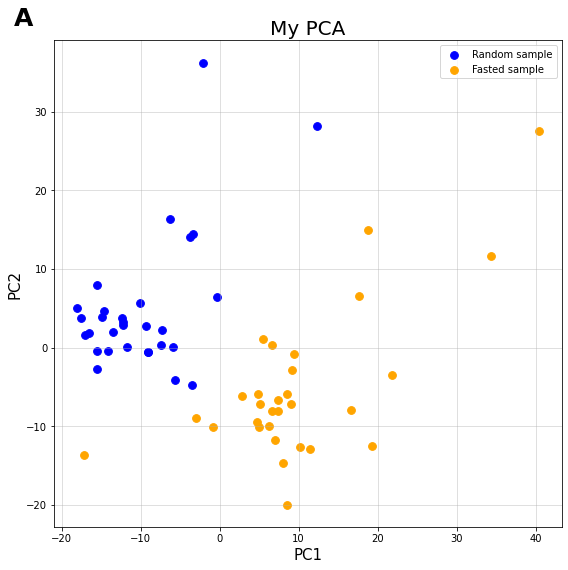

In [46]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('My PCA', fontsize=20)

targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
target_colors = ['blue', 'orange']
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for target, color in zip(targets, target_colors):
    points = pca_data.loc[pca_data['bg_type'] == target]
    ax.scatter(points['pc1'], points['pc2'],
               c=color, cmap='viridis', s=60)
ax.legend(['Random sample', 'Fasted sample'])
ax.grid(alpha=0.5)

ax.text(-0.08, 1.03, "A", transform=ax.transAxes, fontsize=25, weight='bold')

plt.tight_layout()

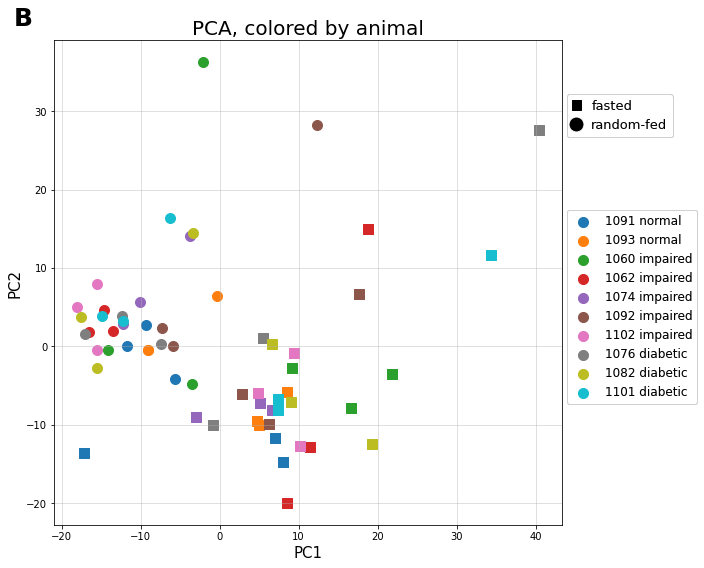

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal', fontsize = 20)
targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []

for target, marker in zip(targets, markers):
    for label, color in zip(animals_used, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & \
                                  (pca_data['animal'] == label)]
#             print(scatter_points)
        handle = ax.scatter(scatter_points['pc1'],
                            scatter_points['pc2'],
                            c = color,
#                             cmap='viridis',
                            marker=marker,
                            s = (110 if marker == 's' else 100))

        # Annotate the plot with number for week 8, 9, 10 (convert to 1, 2, 3 for ease of reading)
#         for index, row in scatter_points.iterrows():
#             week = row['week'] - 7  # Minus 7 to go from week 8->1, 9->2, 10->3
#             ax.annotate(str(week), xy=(row['pc1']-0.5, row['pc2']-0.7), 
#                         fontsize=8, color='white', weight='bold')

        # define the text label for the data handle for the legend:
        gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == label]['glucose_tolerance'].values[0]
        handle.set_label(str(label) + ' ' + gluc_tol)
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
# legend = ax.legend(handles, labels, loc=(1.01, 0.23))

legend = ax.legend(handles[:10], labels[:10], loc=(1.01, 0.25), fontsize=12)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))

legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                             Line2D([0], [0], marker='o', color='white', label='random-fed', 
                                    markerfacecolor='black', markersize=15)], 
                    loc=(1.01, 0.8), 
                    fontsize=13, 
                    handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
ax.add_artist(legend)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')])

ax.text(-0.08, 1.03, "B", transform=ax.transAxes, fontsize=25, weight='bold')
# ax.text(1.072, 0.87, "Animal, feeding, glucose tolerance", transform=ax.transAxes, fontsize=9)

plt.tight_layout()

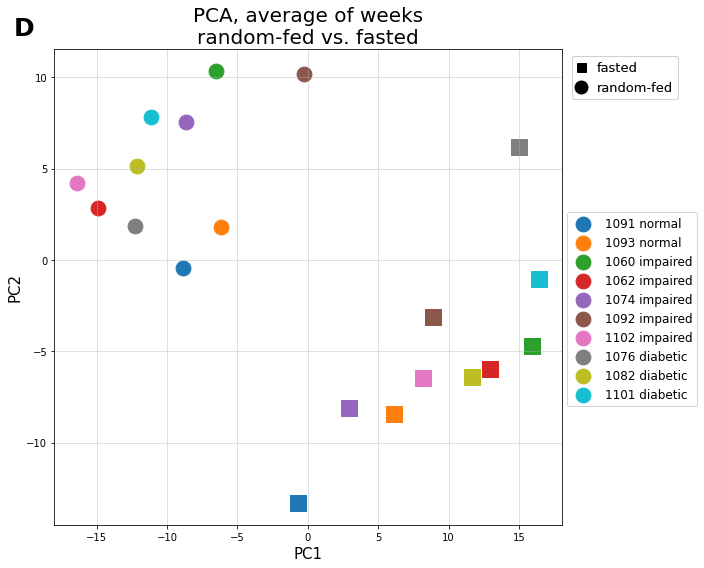

In [49]:
pc_to_plot_x = 1
pc_to_plot_y = 2

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc_to_plot_x), fontsize = 15)
ax.set_ylabel('PC' + str(pc_to_plot_y), fontsize = 15)
ax.set_title('PCA, average of weeks\nrandom-fed vs. fasted', fontsize = 20)

markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []

for rat_label, color in zip(animals_used, colors):
    for bg_type, marker in zip(['RBG', 'FBG'], markers):
        tolerance_type = animal_to_tolerance_dict[rat_label]
        edge_color = None
        if tolerance_type == 'diabetic':
            edge_color = 'lightgray'
        elif tolerance_type == 'impaired':
            edge_color = 'darkgray'
        else: 
            edge_color = 'black'

        scatter_points = pca_data[(pca_data['gluc_tol'] == tolerance_type) & \
                                  (pca_data['animal'] == (rat_label)) & \
                                  (pca_data['bg_type'] == bg_type)].mean(axis=0)
        handle = ax.scatter(scatter_points['pc' + str(pc_to_plot_x)],
                            scatter_points['pc' + str(pc_to_plot_y)],
                            c = color,
                            marker=marker,
#                             edgecolors=edge_color,
#                             linewidths=3,              # linewidths is stroke size of marker outline
                            s = (250 if marker == 's' else 220),
                            )
#         # Annotate the plot with letter for Diabetic, Normal, Impaired
#         ax.annotate(tolerance_type[0].upper(), 
#                     xy=(scatter_points['pc1']-0.5, scatter_points['pc2']-0.7), 
#                     fontsize=20,
#                     color='black')
    
        # define the text label for the data handle for the legend:
#         gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == rat_label]['glucose_tolerance'].values[0]
        handle.set_label(str(rat_label) + ' ' + tolerance_type )
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
legend = ax.legend(handles[::2], labels[::2], loc=(1.01, 0.25), fontsize=12)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))

legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                   Line2D([0], [0], marker='o', color='white', label='random-fed', 
                          markerfacecolor='black', markersize=15)], loc=(1.02, 0.895), fontsize=13, handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)

# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')], loc=(1.01, 0.98))

ax.text(-0.08, 1.03, "D", transform=ax.transAxes, fontsize=25, weight='bold')

plt.tight_layout()